# Машинное обучение, ФКН ВШЭ

# Практическое задание 7. Бустинговое

## Общая информация

Дата выдачи: 06.12.2021

Мягкий дедлайн: 18.12.2021 23:59 MSK

Жёсткий дедлайн: 19.12.2021 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг.

In [43]:
! pip install xgboost

In [106]:
! pip install hyperopt

In [200]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression

sns.set(style='darkgrid')
filterwarnings('ignore')

In [195]:
x = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 1337 для воспроизводимости).

In [196]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга (4 балла)

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

В `__init__` приходит кучка параметров, распишем что есть что:

 - `base_model_class` - класс базовой модели нашего бустинга
 - `base_model_params` - словарь с гиперпараметрами для базовой модели
 - `n_estimators` - какое количество базовых моделей нужно обучить
 - `learning_rate` - темп обучения, должен быть из полуинтервала $(0, 1]$
 - `subsample` - доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей)
 - `early_stopping_rounds` - число итераций, после которых при отсутствии улучшения качества на валидационной выборке обучение останавливается
 - `plot` - строить ли после обучения всех базовых моделей график с качеством

#### `fit`

В `fit` приходит две выборки, обучающая и валидационная. На обучающей мы обучаем новые базовые модели, на валидационной считаем качество для ранней остановки (если это предусматривают параметры).

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания для обучающей и валидационной выборок (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на обучающей и валидационной выборках (используем `loss_fn` для этого), проверить на раннюю остановку.

После всего цикла обучения надо нарисовать график (если `plot`).


#### `fit_new_base_model`

В `fit_new_base_model` приходит обучающая выборка (целиком) и текущие предсказания для неё. Мы должны сгенерировать бутстрап выборку для обучения базовой модели и обучить базовую модель. После обучения модели запускаем поиск оптимальной гаммы, добавляем новую модель и гамму (не забываем про темп обучения) в соответствующие списки.

#### `predict_proba`

В `predict_proba` приходит выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду.

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [206]:
boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

Wall time: 1.63 s
Train ROC-AUC 0.9845
Valid ROC-AUC 0.9167
Test ROC-AUC 0.9121


Wall time: 50.6 s
Train ROC-AUC 0.9926
Valid ROC-AUC 0.9430
Test ROC-AUC 0.9404


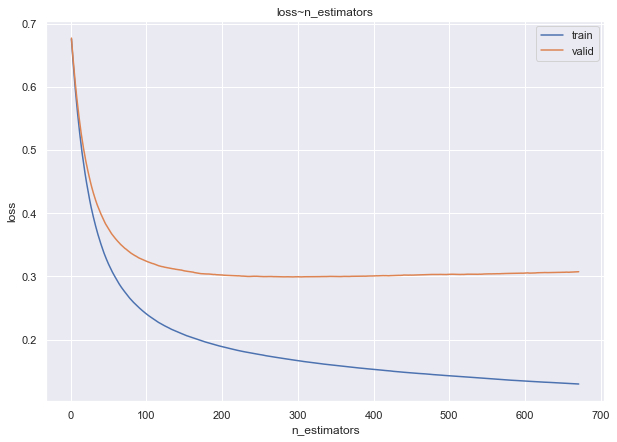

In [208]:
boosting = Boosting(plot = True, n_estimators = 1000, early_stopping_rounds = 10, base_model_params = {"max_depth": 9})

%time boosting.fit(x_train, y_train, x_valid, y_valid)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

## Задание 2. Обучение градиентного бустинга (1 балл)

Оцените качество на тестовой выборке вашей имплементации бустинга для различной максимальной глубины решающего дерева в качестве базовой модели. Здесь и далее мы будем использовать метрику ROC-AUC.

Перебирайте максимальную глубину от 1 до 30 с шагом 2 (остальные параметры бустинга стоит оставить равными по умолчанию). Постройте график зависимости качества на обучающей и тестовой выборке в зависимости от глубины.

In [157]:
results = {}

depths = range(1, 30, 2)

results["depths"] = [] 
results["train_roc_auc"] = []
results["test_roc_auc"] = []

for depth in tqdm(depths):

    boosting = Boosting(base_model_params = {"max_depth": depth}, n_estimators = 100, early_stopping_rounds = 2)
    boosting.fit(x_train, y_train, x_valid, y_valid)
    results["depths"].append(depth)
    results["train_roc_auc"].append(boosting.score(x_train, y_train))
    results["test_roc_auc"].append(boosting.score(x_test, y_test))

# YOUR CODE:

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:33<00:00, 10.21s/it]


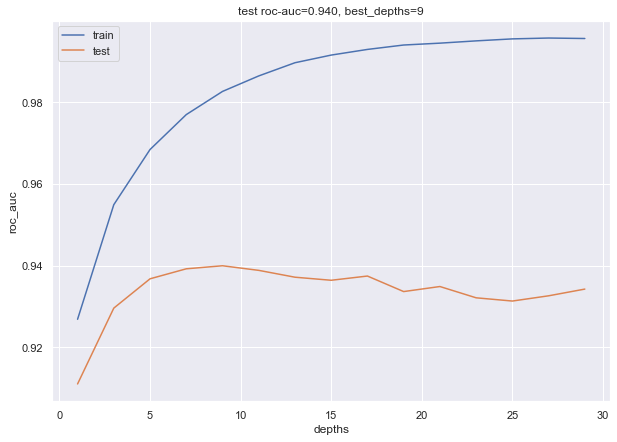

In [158]:
plt.figure(figsize=(10, 7))
plt.plot(results["depths"], results["train_roc_auc"])
plt.plot(results["depths"], results["test_roc_auc"])
plt.xlabel('depths')
plt.ylabel('roc_auc')
plt.legend(['train', 'test'])
plt.title('test roc-auc=%.3f, best_depths=%d' % (np.max(results["test_roc_auc"]), results["depths"][np.array(results["test_roc_auc"]).argmax()]));

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

`### ваше решение тут ###`

## Задание 3. Подбираем гиперпараметры и ищем лучшую модель (2 балла)

Подберите по валидационной выборке основные гиперпараметры для вашей модели бустинга. Следует подобрать все основные параметры для самого градиентного бустинга и для самих базовых моделей.

In [ ]:
# YOUR CODE:
results = {}

depths = range(1, 30, 4)
learning_rates = [1, 0.5, 0.3, 0.1]
n_estimators = range(10, 300, 50)
min_samples_split = [2, 4, 6]
min_samples_leaf = [1, 3, 5]

results["depths"] = []
results["min_samples_split"] = [] 
results["min_samples_leaf"] = [] 
results["learning_rate"] = [] 
results["n_estimators"] = [] 
results["roc_auc"] = []

for learning_rate in  tqdm(learning_rates):
    for n in n_estimators:
        for depth in depths:
            for sample_split in min_samples_split:
                for sample_leaf in min_samples_leaf:

                    boosting = Boosting(base_model_params = {"max_depth": depth, 
                                                             "min_samples_split" : sample_split, 
                                                             "min_samples_leaf" : sample_leaf}, 
                                        n_estimators = n, 
                                        early_stopping_rounds = 2, 
                                        learning_rate = learning_rate)

                    boosting.fit(x_train, y_train, x_valid, y_valid)

                    results["depths"].append(depth)
                    results["min_samples_split"].append(sample_split)
                    results["min_samples_leaf"].append(sample_leaf)
                    results["learning_rate"].append(learning_rate)
                    results["n_estimators"].append(n)
                    results["roc_auc"].append(boosting.score(x_valid, y_valid))

In [164]:
index = np.array(results["roc_auc"]).argmax()
print("roc_auc = %f" % (np.array(results["roc_auc"]).max()))
print("depth = %d" % (results["depths"][index]))
print("learning_rate = %f" % (results["learning_rate"][index]))
print("n_estimators = %f" % (results["n_estimators"][index]))
print("min_samples_leaf = %d" % (results["min_samples_leaf"][index]))
print("min_samples_split = %d" % (results["min_samples_split"][index]))

roc_auc = 0.943889
depth = 5
learning_rate = 0.300000
n_estimators = 160.000000
min_samples_leaf = 5
min_samples_split = 6


In [54]:
boosting = Boosting(base_model_params = {"max_depth": 5, "min_samples_split" : 6, "min_samples_leaf" : 5}, 
                                        n_estimators = 160, 
                                        early_stopping_rounds = 2, 
                                        learning_rate = 0.3)

boosting.fit(x_train, y_train, x_valid, y_valid)
boosting.score(x_test, y_test)

0.9393393090787139

## Задание 4. Пробуем разные библиотеки (2 балла)

Выберите себе библиотеку с реализацией градиентного бустинга по вкусу из следующих трёх - [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html), [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html), [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart). Подберите основные гиперпараметры, постарайтесь добиться наилучшего качества на тестовых данных. Сравните результаты своей реализации с результатами библиотечного бустинга.

In [67]:
# YOUR CODE:
import xgboost as xgb
from xgboost import XGBClassifier

In [104]:
dtrain = xgb.DMatrix(x_train, np.where(y_train == 1, 1, 0))
boosting = xgb.train(param, dtrain)
dtest = xgb.DMatrix(x_test)
y_pred = boosting.predict(dtest)
roc_auc_score(y_test== 1, y_pred)

0.9302831892405093

In [101]:
n_estimators = range(10, 200, 30)
max_depths = range(1, 20, 4)
learning_rates = [1, 0.5, 0.3, 0.1]
gammas = [1, 0.5, 0.3, 0.1]

results["n_estimators"] = []
results["max_depths"] = [] 
results["learning_rates"] = [] 
results["gammas"] = [] 
results["roc_auc"] = []

for learning_rate in  tqdm(learning_rates):
    for n in n_estimators:
        for max_depth in max_depths:
            for n in n_estimators:
                for gamma in gammas:

                    boosting = XGBClassifier(n_estimators = n, 
                                             max_depth = max_depth, 
                                             learning_rate = learning_rate,
                                             gamma = gamma)
                    
                    boosting.fit(x_train, y_train == 1)
                    
                    roc_auc_score(y_test== 1, boosting.predict_proba(x_test)[:, 1])
                    
                    
                    results["max_depths"].append(max_depth)
                    results["n_estimators"].append(n)
                    results["learning_rates"].append(learning_rate)
                    results["gammas"].append(gamma)
                    results["roc_auc"].append(roc_auc_score(y_test== 1, boosting.predict_proba(x_test)[:, 1]))

In [103]:
index = np.array(results["roc_auc"]).argmax()
print("max_roc_auc = %f" % (np.max(results["roc_auc"])))
print("max_depth = %d" % (results["max_depths"][index]))
print("n_estimators = %d" % (results["n_estimators"][index]))
print("learning_rate = %f" % (results["learning_rates"][index]))
print("gamma = %f" % (results["gammas"][index]))

max_roc_auc = 0.940834
max_depth = 5
n_estimators = 160
learning_rate = 0.100000
gamma = 0.300000


### Задание 5 (бонус). Пробуем ещё немножко библиотек (1 балл)

Существуют библиотеки для подбора гиперпараметров, попробуйте использовать какую-нибудь из следующих двух - [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://optuna.org/). Сравните полученное качество с вашим ручным перебором. Используйте эту библиотеку чтобы подобрать параметры и для своей реалзиации и для библиотечной.

In [117]:
# YOUR CODE:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

import warnings

def objective(space):

    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma']
                            )
    
    classifier.fit(x_train, y_train == 1)
    
    roc_auc = roc_auc_score(y_test == 1, classifier.predict_proba(x_test)[:, 1])

    return{'loss':1 - roc_auc, 'status': STATUS_OK }

space = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 1, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(1, 20, 1, dtype=int)),
    'gamma':            hp.choice('gamma',            np.arange(0.05, 1, 0.1)),
    'n_estimators':     hp.choice('n_estimators',     np.arange(10, 300, 10))
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print("Best: ", best)

In [146]:
print("max_roc_auc = %f" % (1 - 0.059437699469236716))
print("max_depth = %d" % (np.arange(1, 20, 1, dtype=int)[best["max_depth"]]))
print("n_estimators = %d" % (np.arange(10, 300, 10)[best["n_estimators"]]))
print("learning_rate = %f" % (np.arange(0.05, 1, 0.05)[best["learning_rate"]]))
print("gamma = %f" % (np.arange(0.05, 1, 0.1)[best["gamma"]]))

max_roc_auc = 0.940562
max_depth = 5
n_estimators = 140
learning_rate = 0.100000
gamma = 0.350000


In [149]:
# YOUR CODE:

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

import warnings

def objective(space):

    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    
    classifier = Boosting(base_model_params = {"max_depth": int(space['max_depth']), 
                                               "min_samples_split" : int(space['min_samples_split']), 
                                               "min_samples_leaf" : int(space['min_samples_leaf'])}, 
                                        n_estimators = space['n_estimators'], 
                                        early_stopping_rounds = 2, 
                                        learning_rate = space['learning_rate'])
       
    classifier.fit(x_train, y_train, x_valid, y_valid)

    roc_auc = roc_auc_score(y_test == 1, classifier.predict_proba(x_test)[:, 1])
    
#     print("roc_auc:", roc_auc)

    return{'loss':1 - roc_auc, 'status': STATUS_OK }

space = {
    'learning_rate':      hp.choice('learning_rate',      np.arange(0.05, 1, 0.05)),
    'max_depth':          hp.choice('max_depth',          np.arange(1, 20, 1, dtype=int)),
    'gamma':              hp.choice('gamma',              np.arange(0.05, 1, 0.1)),
    'n_estimators':       hp.choice('n_estimators',       np.arange(10, 300, 10)),
    'min_samples_split':  hp.choice('min_samples_split',  np.arange(2, 5, 1, dtype=int)),
    'min_samples_leaf':   hp.choice('min_samples_leaf',   np.arange(1, 5, 1, dtype=int)),
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print("Best: ", best)

100%|████████████████████████████████████████████| 100/100 [08:21<00:00,  5.01s/trial, best loss: 0.060037976895813916]
Best:  {'gamma': 7, 'learning_rate': 7, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 1, 'n_estimators': 27}


In [152]:
print("max_roc_auc = %f" % (1 - 0.060037976895813916))
print("max_depth = %d" % (np.arange(1, 20, 1, dtype=int)[best["max_depth"]]))
print("min_samples_split = %d" % np.arange(2, 5, 1, dtype=int)[best["min_samples_split"]])
print("min_samples_leaf = %d" % np.arange(1, 5, 1, dtype=int)[best["min_samples_leaf"]])
print("n_estimators = %d" % (np.arange(10, 300, 10)[best["n_estimators"]]))
print("learning_rate = %f" % (np.arange(0.05, 1, 0.05)[best["learning_rate"]]))
print("gamma = %f" % (np.arange(0.05, 1, 0.1)[best["gamma"]]))

max_roc_auc = 0.939962
max_depth = 6
min_samples_split = 3
min_samples_leaf = 4
n_estimators = 280
learning_rate = 0.400000
gamma = 0.750000


## Задание 6. Интерпретация бустингового (1 балл)

Постройте калибровочную кривую для вашей лучшей модели бустинга (из тех, что используют вашу реализацию).
Насколько хорошо бустинг оценивает вероятности? Постройте также калибровочную кривую для логистической регресии, сравните их между собой. Проанализируйте полученные результаты.

In [125]:
boosting = Boosting(base_model_params = {"max_depth": 5, "min_samples_split" : 6, "min_samples_leaf" : 5}, 
                                        n_estimators = 160, 
                                        early_stopping_rounds = 2, 
                                        learning_rate = 0.3)

boosting.fit(x_train, y_train, x_valid, y_valid)
y_pred_prob = boosting.predict_proba(x_test)

In [61]:
# YOUR CODE:
svc_true_prob, svc_pred_prob = calibration_curve(y_test, y_pred_prob[:, 1], n_bins=15)


In [63]:
lr = LogisticRegression(max_iter=100000, C=0.1).fit(x_train, y_train)
lr_pred = lr.predict_proba(x_test)[:, 1]
lr_true_prob, lr_pred_prob = calibration_curve(y_test, lr_pred, n_bins=15)

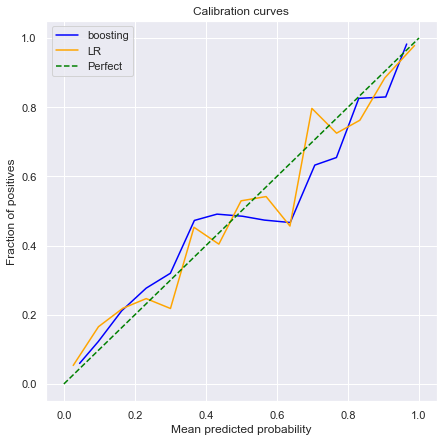

In [182]:
plt.figure(figsize=(7, 7))

plt.plot(svc_pred_prob, svc_true_prob, label='boosting', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

Теперь попробуем оценить важность признаков для бустинга.

Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так).

Допишите в вашей реализации бустинга функцию `feature_importances_` чтобы она возвращала описанные выше важности признаков.

Нарисуйте столбчатую диаграмму важности признаков. На соседнем графике нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Проанализируйте полученные результаты.

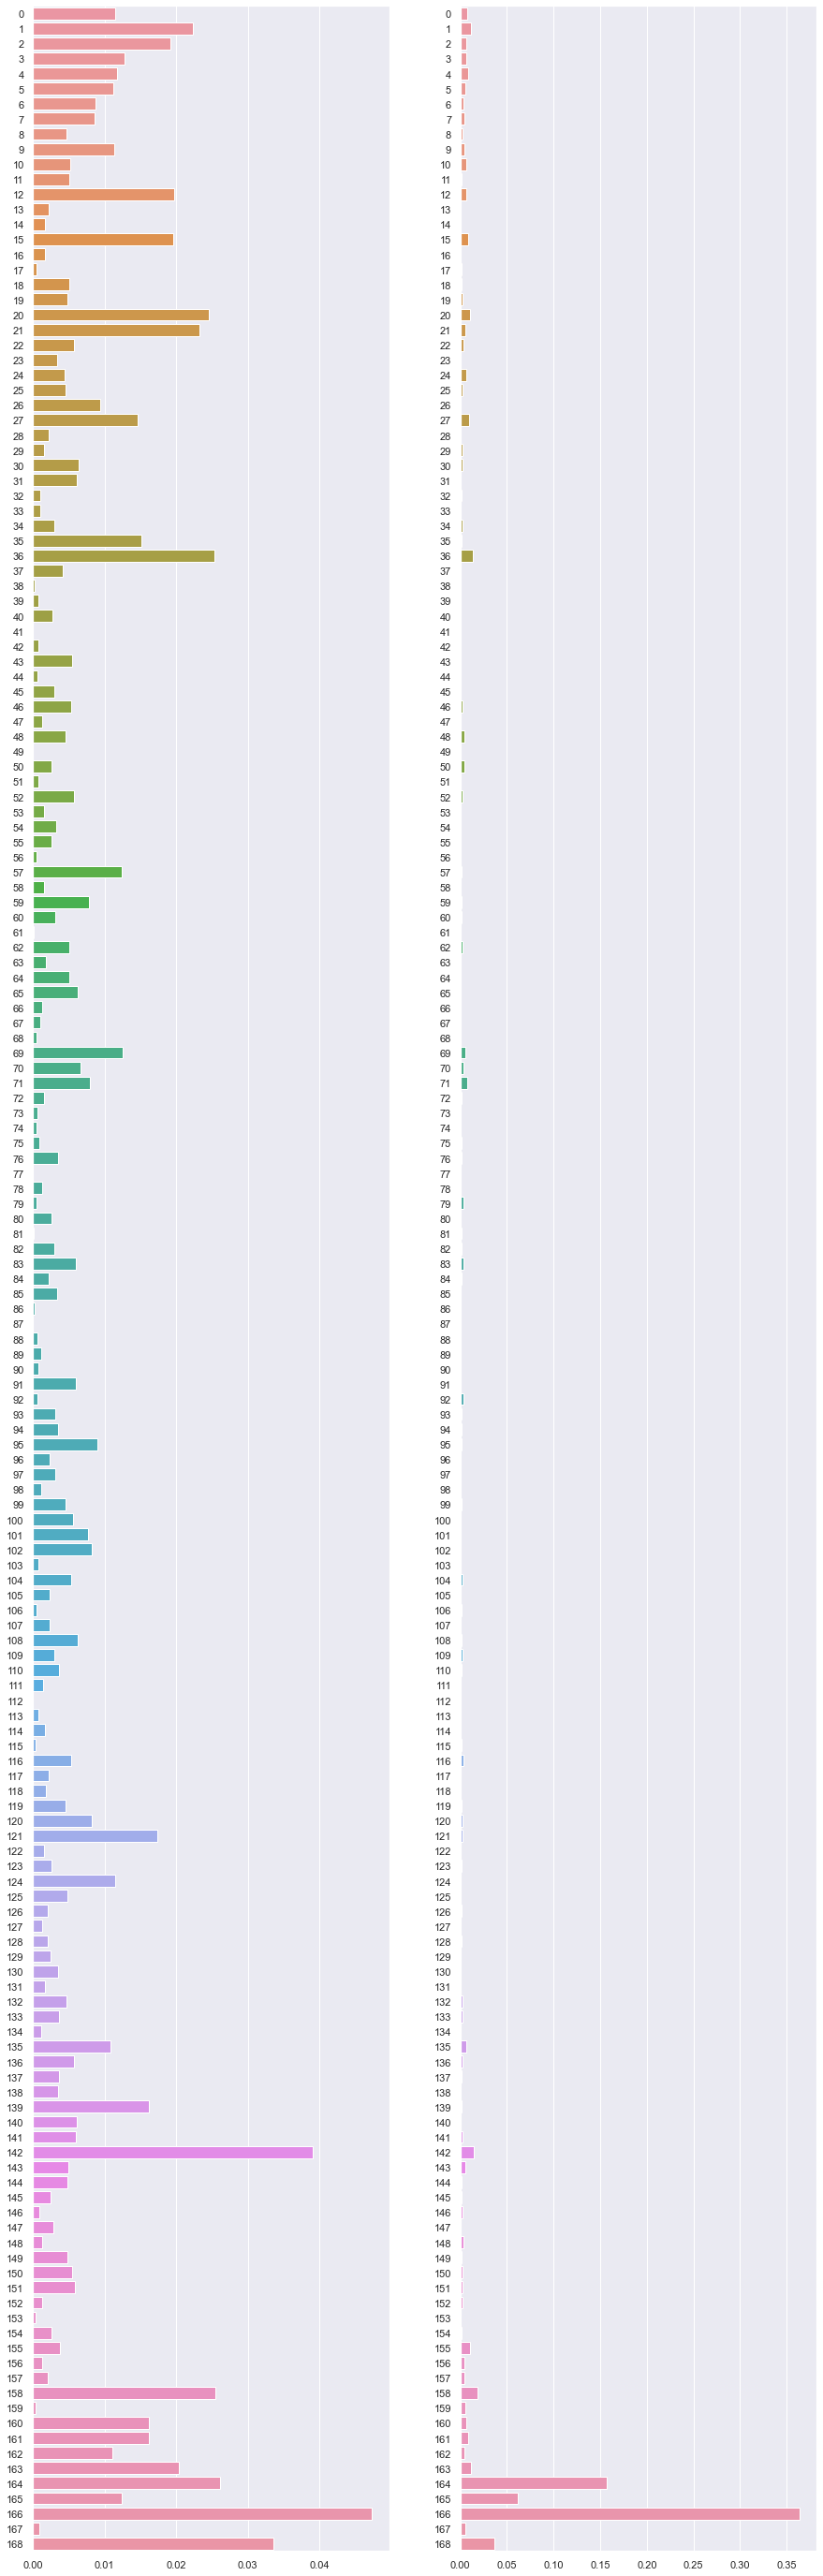

In [126]:
# YOUR CODE:

feature_importances_mean = boosting.feature_importances_

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,50))
sns.barplot(y=np.arange(len(feature_importances_mean)), x=(np.abs(lr.coef_[0]) / np.sum(np.abs(lr.coef_[0]))), orient = "h", ax=ax0)
sns.barplot(y=np.arange(len(feature_importances_mean)), x=feature_importances_mean, orient = "h", ax=ax1) ;


Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (с теми же гиперпараметрами). Стало ли лучше?

In [187]:
boosting = Boosting(base_model_params = {"max_depth": 5, "min_samples_split" : 6, "min_samples_leaf" : 5}, 
                                        n_estimators = 160, 
                                        early_stopping_rounds = 2, 
                                        learning_rate = 0.3)

boosting.fit(x_train, y_train, x_valid, y_valid)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

Train ROC-AUC 0.9755
Valid ROC-AUC 0.9414
Test ROC-AUC 0.9400


In [193]:
index = feature_importances_mean > 0.005

x_train_part = x_train[:,index]
x_valid_part = x_valid[:,index]
x_test_part = x_test[:,index]

boosting = Boosting(base_model_params = {"max_depth": 5, "min_samples_split" : 6, "min_samples_leaf" : 5}, 
                                        n_estimators = 160, 
                                        early_stopping_rounds = 2, 
                                        learning_rate = 0.3)

boosting.fit(x_train_part, y_train, x_valid_part, y_valid)

print(f'Train ROC-AUC {boosting.score(x_train_part, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid_part, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test_part, y_test):.4f}')

Train ROC-AUC 0.9729
Valid ROC-AUC 0.9407
Test ROC-AUC 0.9378


## Задание 7 (бонус). Блендинговое (1 балл)

Реализуйте блендинг над вашими лучшими моделями (ваша реализация с лучшими гиперпараметрами + все модели из библиотек с лучшими гиперпараметрами). Улучшилось ли качество?

In [ ]:
# YOUR CODE:

## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2022 года?